In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

TensorFlow 2.x selected.


## Data Load

In [0]:
import pandas as pd
import os

colabdir = '/content/drive/My Drive/Colab Notebooks'

old_data = pd.read_csv(os.path.join(colabdir,'old_rev.txt'),sep='\t', header=None)
new_data = pd.read_csv(os.path.join(colabdir,'new_rev.txt'),sep='\t', header=None)
old_data.columns = ['idx','contents']
new_data.columns = ['idx','contents']

In [0]:
df_b = pd.merge(new_data, old_data,on='idx', how='inner')
df_b.columns = ['idx','new','old']

In [0]:
df_b.dropna(inplace=True)

In [45]:
df_b.head()

,idx,new,old
0,창1:1,태초에 하나님이 우주를 창조하셨다.,태초에 하나님이 천지를 창조하시니라
1,창1:2,지구는 아무 형태도 없이 텅 비어 흑암에 싸인 채 물로 뒤덮여 있었고 하나님의 영은...,그 땅이 혼돈하고 공허하며 흑암이 깊음 위에 있고 하나님의 영은 수면 위에 운행하시니라
2,창1:3,그때 하나님이 '빛이 있으라' 라고 말씀하시자 빛이 나타났다.,하나님이 이르시되 빛이 있으라 하시니 빛이 있었고
3,창1:4,그 빛은 하나님이 보시기에 좋았다. 하나님이 빛과 어두움을 나누어,그 빛이 하나님이 보시기에 좋았더라 하나님이 빛과 어둠을 나누사
4,창1:5,빛을 낮이라 부르시고 어두움을 밤이라고 부르셨다. 저녁이 지나고 아침이 되자 이것이...,하나님이 빛을 낮이라 부르시고 어둠을 밤이라 부르시니라 저녁이 되고 아침이 되니 이...


In [46]:
s = '나 배고파 이색귀야.'
s.strip()

'나 배고파 이색귀야.'

In [47]:
''.join(c for c in unicodedata.normalize('NFD', s))

'나 배고파 이색귀야.'

In [0]:
# make a space between words and puncts
def preprocess_sentence(w):
  w = re.sub(r'([?.!,])', r' \1 ', w)
  w = re.sub(r'[" "]+', " ", w)
  
  # replacing everything and with space except (가-힣, ".", "?", "!", ",")
  w = re.sub(r"[^가-힣?.!,]+", " ", w)
  
  w = w.rstrip().strip()
  
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [49]:
new_sentence = "오늘 날씨가 참 좋구나!"
old_sentence = "오늘 날씨가 참 좋아"
print(preprocess_sentence(new_sentence))
print(preprocess_sentence(old_sentence))

<start> 오늘 날씨가 참 좋구나 ! <end>
<start> 오늘 날씨가 참 좋아 <end>


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format : [new, old]
df_b.new = df_b.new.apply(lambda x: preprocess_sentence(x))
df_b.old = df_b.old.apply(lambda x: preprocess_sentence(x))

In [51]:
df_b.head()

,idx,new,old
0,창1:1,<start> 태초에 하나님이 우주를 창조하셨다 . <end>,<start> 태초에 하나님이 천지를 창조하시니라 <end>
1,창1:2,<start> 지구는 아무 형태도 없이 텅 비어 흑암에 싸인 채 물로 뒤덮여 있었고...,<start> 그 땅이 혼돈하고 공허하며 흑암이 깊음 위에 있고 하나님의 영은 수면...
2,창1:3,<start> 그때 하나님이 빛이 있으라 라고 말씀하시자 빛이 나타났다 . <end>,<start> 하나님이 이르시되 빛이 있으라 하시니 빛이 있었고 <end>
3,창1:4,<start> 그 빛은 하나님이 보시기에 좋았다 . 하나님이 빛과 어두움을 나누어 ...,<start> 그 빛이 하나님이 보시기에 좋았더라 하나님이 빛과 어둠을 나누사 <end>
4,창1:5,<start> 빛을 낮이라 부르시고 어두움을 밤이라고 부르셨다 . 저녁이 지나고 아...,<start> 하나님이 빛을 낮이라 부르시고 어둠을 밤이라 부르시니라 저녁이 되고 ...


In [52]:
df_b.new.values

array(['<start> 태초에 하나님이 우주를 창조하셨다 . <end>',
       '<start> 지구는 아무 형태도 없이 텅 비어 흑암에 싸인 채 물로 뒤덮여 있었고 하나님의 영은 수면이 활동하고 계셨다 . <end>',
       '<start> 그때 하나님이 빛이 있으라 라고 말씀하시자 빛이 나타났다 . <end>', ...,
       '<start> 또 누구든지 이 예언의 말씀에서 무엇을 빼면 하나님이 이 책에 기록된 생명나무와 거룩한 성에 참여하는 특권을 빼앗아 버리실 것입니다 . <end>',
       '<start> 이 모든 것을 증거하신 분이 말씀하십니다 . 내가 속히 가겠다 . 아멘 . 주 예수님 , 어서 오십시오 . <end>',
       '<start> 주 예수님의 은혜가 모든 성도들과 함께 하기를 기도합니다 . 아멘 . <end>'],
      dtype=object)

In [0]:
new = df_b.new.values
old = df_b.old.values

## The distribution of length

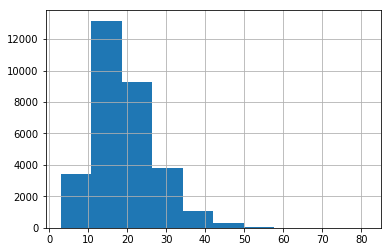

In [83]:
pd.Series(new).apply(lambda x:len(x.split(' '))).hist()

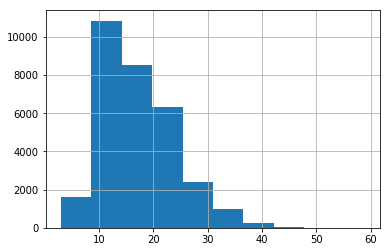

In [82]:
pd.Series(old).apply(lambda x: len(x.split(' '))).hist()

In [0]:
# 한 35정도까지만 해도 될듯..?

## Remove shorter than the 35

In [0]:
df_b = df_b[(df_b.new.apply(lambda x: len(x.split(' ')))<35) & (df_b.old.apply(lambda x: len(x.split(' ')))<35)]

In [0]:
df_b = df_b[df_b.new!='<start> 절과 같음 <end>']

In [91]:
df_b.head()

,idx,new,old
0,창1:1,<start> 태초에 하나님이 우주를 창조하셨다 . <end>,<start> 태초에 하나님이 천지를 창조하시니라 <end>
1,창1:2,<start> 지구는 아무 형태도 없이 텅 비어 흑암에 싸인 채 물로 뒤덮여 있었고...,<start> 그 땅이 혼돈하고 공허하며 흑암이 깊음 위에 있고 하나님의 영은 수면...
2,창1:3,<start> 그때 하나님이 빛이 있으라 라고 말씀하시자 빛이 나타났다 . <end>,<start> 하나님이 이르시되 빛이 있으라 하시니 빛이 있었고 <end>
3,창1:4,<start> 그 빛은 하나님이 보시기에 좋았다 . 하나님이 빛과 어두움을 나누어 ...,<start> 그 빛이 하나님이 보시기에 좋았더라 하나님이 빛과 어둠을 나누사 <end>
4,창1:5,<start> 빛을 낮이라 부르시고 어두움을 밤이라고 부르셨다 . 저녁이 지나고 아...,<start> 하나님이 빛을 낮이라 부르시고 어둠을 밤이라 부르시니라 저녁이 되고 ...


In [0]:
new = df_b.new.values
old = df_b.old.values

## Function definition

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [0]:
input_tensor, inp_lang = tokenize(new)
target_tensor, targ_lang = tokenize(old)
max_length_inp, max_length_targ = max_length(new), max_length(old)

In [96]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val =\
    train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

22968 22968 5743 5743


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [98]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
21 ----> 그리고
13 ----> 여호와께서
261 ----> 모세에게
59 ----> 말씀하셨다
1 ----> .
42 ----> 너는
683 ----> 아론과
6451 ----> 나답과
13722 ----> 아비후와
31 ----> 이스라엘
4490 ----> 장로
2055 ----> 명과
30 ----> 함께
58 ----> 나
473 ----> 여호와에게
3803 ----> 올라와
2635 ----> 멀리서
2636 ----> 경배하고
3 ----> <end>

Target Language; index to word mapping
1 ----> <start>
12 ----> 또
199 ----> 모세에게
32 ----> 이르시되
44 ----> 너는
712 ----> 아론과
3924 ----> 나답과
6850 ----> 아비후와
30 ----> 이스라엘
3943 ----> 장로
1370 ----> 칠십
1929 ----> 명과
26 ----> 함께
1568 ----> 여호와께로
2615 ----> 올라와
3904 ----> 멀리서
3047 ----> 경배하고
2 ----> <end>


## Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [100]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 34]), TensorShape([64, 34]))

## Write the encoder and decoder model

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  
  # call method!로 부르기
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [106]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 34, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanuAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanuAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
    
  def call(self, query, values):
    # query => hidden(from decoder), values => encoder output(y value)
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape = (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query,1) # 가운데에 차원 만들기
    
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
    # broadcasting?
    # hidden_with_time_axis => last hidden vector (dim + 1)
    # values : output / query : hidden
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    # broadcasting?
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [143]:
attention_layer = BahdanuAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch_size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch_size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 34, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    # vocab_size => to make a suggestion!
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    
    # used for attention
    self.attention = BahdanuAttention(self.dec_units)
    
  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    # why time_step is 1 => seq2seq?
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    
    # output shape == (batch_size, vocab)
    x = self.fc(output)
    
    return x, state, attention_weights

In [147]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64,1)),
                                      sample_hidden, sample_output)

print('Decoder output shape : (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))

Decoder output shape : (batch_size, vocab_size) (64, 57452)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
# make optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# make loss_object

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # if real = F -> T / T -> F
  loss_ = loss_object(real, pred)
  # put real / pred
  
  mask = tf.cast(mask, dtype=loss_.dtype)
  # F -> 0 / T -> 1
  loss_ *= mask
  # element-wise multiply
  
  return tf.reduce_mean(loss_)

## Checkpoints

In [0]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(colabdir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training
  1. Pass the input through the encoder which return encoder output and the encoder hidden state.
  2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
  3. The decoder returns the predictions and the decoder hidden state.
  4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
  5. Use teacher forcing to decide the next input to the decoder
  6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
  7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [168]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5678
Epoch 1 Batch 100 Loss 3.9879
Epoch 1 Batch 200 Loss 3.5775
Epoch 1 Batch 300 Loss 3.8247
Epoch 1 Loss 3.9671
Time taken for 1 epoch 607.2236704826355 sec

Epoch 2 Batch 0 Loss 3.7304


KeyboardInterrupt: ignored

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  
  sentence = preprocess_sentence(sentence)
  
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  
  result = ''
  
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)
  
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
  
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    
    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    
    predicted_id = tf.argmax(predictions[0]).numpy()
    
    result += targ_lang.index_word[predicted_id] + ' '
    
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
    
  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [179]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(colabdir))

ERROR:tensorflow:Couldn't match files for checkpoint /content/drive/My Drive/Colab Notebooks/MLpymodel_mnist_fashion_cnn_WRN_revised_0819_BN_cost_dropout.ckpt


In [182]:
translate(u'쉬 발')

KeyError: ignored

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

md = Sequential()

md.add(LSTM(32, input_shape=(3,30), return_sequences=True)) # hidden state, time step, # of input feature
# 요 상태에서 Dense를 쓰면 맨 팅에 차원끼리만 FC layer로 묶인 것!
md.add(Dense(10))
md.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3, 32)             8064      
_________________________________________________________________
dense_10 (Dense)             (None, 3, 10)             330       
Total params: 8,394
Trainable params: 8,394
Non-trainable params: 0
_________________________________________________________________
